# Utilities

### Libraries

In [1]:
# data manipulation
import numpy as np
import pandas as pd
from typing import List, Tuple, Dict, Sequence, Union, Optional, Any
from math import comb, gamma, log
from scipy.special import digamma
import matplotlib.pyplot as plt
import itertools
from itertools import combinations
import random

# data preprocessing
from sklearn.preprocessing import StandardScaler

# mutual information
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed

# classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate, RepeatedStratifiedKFold
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, balanced_accuracy_score
import shap

# qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter, SuzukiTrotter
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# saving and loading
import json
import os

### Hyperparameters

In [138]:
N_TROTTER_STEPS = 1
DELTA_T = 0.005
T = N_TROTTER_STEPS * DELTA_T
SEED = 42
OPTIMIZATION_LEVEL = 3
NUM_QUBITS = 80
K_MAX = 3
Q_KS_FOR_AUG = [1,2]
GAMMA_Q = 1.0
RHO_THRESHOLD = 0.0
NUM_FEATURES_SHAP = 50
N_SPLITS = 2
N_REPEATS = 1
NUM_BLOCKS = 10
K=3
ORDER=2
REPS=1

### Load and preprocess dataset

In [5]:
def load_dataset(dataset_dir):
    df = pd.read_csv(dataset_dir)
    df['Class'] = df['Class'].map({'NonToxic': 1,'Toxic': 0})
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    return X, y

# feature reduction to match number of qubits in qpu
def reduce_features(X, y, n_features):
    if X.shape[1] <= n_features:
        return X
    else:
        mi = mutual_info_classif(X, y, n_neighbors=5, discrete_features=False, random_state=SEED)
        mi_indices = np.argsort(mi)[-n_features:]
        return X[:, mi_indices]

def data_preprocessing(X_train, X_test):
    scaler = StandardScaler() # Rescale the data using z-score: (x - μ (mean))/μ (standard deviation)
    X_tr = scaler.fit_transform(X_train)
    Xte = scaler.transform(X_test)
    return X_tr, Xte

In [140]:
path = "C:/Users/jiriv/Documents/škola/Diplom_thesis/Quantum-feature-maps/Dataset/data.csv"
X_raw, y_raw = load_dataset(path)
print(X_raw.shape, y_raw.shape)
X_reduced = reduce_features(X_raw, y_raw, NUM_QUBITS)
print(X_reduced.shape)

(171, 1203) (171,)
(171, 80)


# Circuit creation

### C_s calculation

In [26]:
# doublets
def calculate_MI_matrix(X):
    num_features = X.shape[1]
    MI = np.zeros((num_features, num_features))
    for i in range(num_features):
        for j in range(i+1, num_features):
            MI[i, j] = mutual_info_regression(
                X[:, [i]],
                X[:, j],
                random_state=SEED
            )[0]
            MI[j, i] = MI[i, j]

    MI_norm = MI / (MI.max() + 1e-12)
    return MI_norm

def calculate_Jij_dict(X):
    MI_norm = calculate_MI_matrix(X)
    Jij_dict = {}
    num_features = X.shape[1]
    for i in range(num_features):
        for j in range(i+1, num_features):
            Jij_dict[(i, j)] = MI_norm[i, j]
    return Jij_dict

def create_combinations(X):
    num_features = X.shape[1]
    MI_matrix = calculate_MI_matrix(X)
    combinations = [(i, j) for i in range(num_features) for j in range(i+1, num_features) if MI_matrix[i, j] >= RHO_THRESHOLD]
    return combinations

# triplets

def calculate_MI_triplet_matrix(X):
    """
    MI_triplet[i, j, k] ≈ I([Xi, Xj]; Xk)
    Symmetrized across permutations.
    """
    num_features = X.shape[1]
    MI_triplet = np.zeros((num_features, num_features, num_features))

    for i in range(num_features):
        for j in range(i + 1, num_features):
            for k in range(j + 1, num_features):

                mi_ij_k = mutual_info_regression(
                    X[:, [i, j]], X[:, k], random_state=SEED
                )[0]

                mi_ik_j = mutual_info_regression(
                    X[:, [i, k]], X[:, j], random_state=SEED
                )[0]

                mi_jk_i = mutual_info_regression(
                    X[:, [j, k]], X[:, i], random_state=SEED
                )[0]

                # Symmetrize
                mi_avg = (mi_ij_k + mi_ik_j + mi_jk_i) / 3.0

                MI_triplet[i, j, k] = mi_avg
                MI_triplet[i, k, j] = mi_avg
                MI_triplet[j, i, k] = mi_avg
                MI_triplet[j, k, i] = mi_avg
                MI_triplet[k, i, j] = mi_avg
                MI_triplet[k, j, i] = mi_avg

    MI_triplet_norm = MI_triplet / (MI_triplet.max() + 1e-12)
    return MI_triplet_norm


def calculate_Jijk_dict(X):
    MI_triplet_norm = calculate_MI_triplet_matrix(X)
    Jijk_dict = {}
    num_features = X.shape[1]
    for i in range(num_features):
        for j in range(i+1, num_features):
            for k in range(j+1, num_features):
                Jijk_dict[(i, j, k)] = MI_triplet_norm[i, j, k]
    return Jijk_dict

def create_triplet_combinations(X):
    num_features = X.shape[1]
    MI_triplet_matrix = calculate_MI_triplet_matrix(X)
    triplet_combinations = [
        (i, j, k)
        for i in range(num_features)
        for j in range(i + 1, num_features)
        for k in range(j + 1, num_features)
        if MI_triplet_matrix[i, j, k] >= RHO_THRESHOLD
    ]
    return triplet_combinations

test J_ij, J_ijk

In [100]:
doublets = create_combinations(X_reduced)
print(len(doublets))
J_ij_dict = calculate_Jij_dict(X_reduced)
print(J_ij_dict)
print("--------------")
triplets = create_triplet_combinations(X_reduced)
print(len(triplets))
J_ijk_dict = calculate_Jijk_dict(X_reduced)
print(J_ijk_dict)

45
{(0, 1): np.float64(0.06280107884266241), (0, 2): np.float64(0.10182694194546106), (0, 3): np.float64(0.04448125548573239), (0, 4): np.float64(0.06453556316704281), (0, 5): np.float64(0.021107430582665246), (0, 6): np.float64(0.14678287583716657), (0, 7): np.float64(0.02202775005933802), (0, 8): np.float64(0.069859994179215), (0, 9): np.float64(0.04487060770447322), (1, 2): np.float64(0.13931309043440918), (1, 3): np.float64(0.019216664664436164), (1, 4): np.float64(0.004431397315874252), (1, 5): np.float64(0.06923380385040474), (1, 6): np.float64(0.16888626452279948), (1, 7): np.float64(0.08863811509423851), (1, 8): np.float64(0.1522436570775268), (1, 9): np.float64(0.09414150981302168), (2, 3): np.float64(0.16858709012774506), (2, 4): np.float64(0.012442143212677488), (2, 5): np.float64(0.22667280233121184), (2, 6): np.float64(0.282412272287597), (2, 7): np.float64(0.33013501952592245), (2, 8): np.float64(0.15814322019861568), (2, 9): np.float64(0.3692135715251848), (3, 4): np.flo

### Alpha calculation

In [110]:
def makeRt(h_x, J_dict, s, sum_hi2, sum_Jij2):
    sum_hi4 = 0
    sum_Jij4 = 0

    for hi in h_x:
        sum_hi4 += hi**4

    for (i,j), Jij in J_dict.items():
        sum_Jij4 += Jij**4

    N = len(h_x)  

    sum_hi2Jii2 = 0
    for (i,j), Jij in J_dict.items():  #i<j
        hi = h_x[i]
        hj = h_x[j]
        sum_hi2Jii2 += (hi**2 + hj**2)*(Jij**2)

    contrib_duplet = 2 * 6 * sum_hi2Jii2  # pois i<>j

    sum_triplet = 0.0
    for i, j, k in combinations(range(N), 3):  # i<j<k
        #Jij = J_dict[(i, j)]
        #Jik = J_dict[(i, k)]
        #Jjk = J_dict[(j, k)]
        Jij = J_dict.get((i, j), 0.0)
        Jik = J_dict.get((i, k), 0.0)
        Jjk = J_dict.get((j, k), 0.0)

        sum_triplet += (Jij**2 * Jik**2 +
                        Jij**2 * Jjk**2 +
                        Jik**2 * Jjk**2)

    
    contrib_triplet = 6.0 * sum_triplet  # i<j<k

    Rt = ((1 - s)**2)*(sum_hi2 + 4*sum_Jij2) + (s**2)*(sum_hi4 + 2*sum_Jij4 + contrib_duplet + contrib_triplet)
    # Rt = ((1 - s)**2)*(sum_hi2 + 4*sum_Jij2) + (s**2)*(sum_hi4 + sum_Jij4 + contrib_duplet + contrib_triplet)

    return Rt

def makeAlpha1(h_x, J_dict, s):
    sum_hi2 = 0
    sum_Jij2 = 0

    for hi in h_x:
        sum_hi2 += hi**2

    for (i,j), Jij in J_dict.items():
        sum_Jij2 += Jij**2

    alpha1 = -(1/4)*(sum_hi2 + 2*sum_Jij2) # aqui tem um fator 2 que falta no paper porque o correto é \sum_{i<>j} e não \sum_{i<j}
    Rt = makeRt(h_x, J_dict, s, sum_hi2, 2*sum_Jij2)
    alpha1 = alpha1/Rt

    return alpha1

### H counterdiabatic

In [118]:
"""
def make_Hcd(h_x, J_dict, s, ds):
    n = len(h_x)
    terms_HP = []
    for i, hi in enumerate(h_x):
        if hi != 0: terms_HP.append(("I"*i + "Y" + "I"*(n-i-1), float(hi)))
    if K_MAX == 2:
        for (i,j), Jij in J_dict.items():
            YZ = ["I"]*n 
            ZY = ["I"]*n 
            YZ[i]= 'Y'
            YZ[j]= 'Z'
            ZY[i]= 'Z'
            ZY[j]= 'Y'        
            terms_HP.append(("".join(YZ), float(Jij)))
            terms_HP.append(("".join(ZY), float(Jij)))
        alpha1 = makeAlpha1(h_x, J_dict, s)
    if K_MAX == 3:
        for (i,j,k), Jijk in J_dict.items():
            YZZ = ["I"]*n 
            ZYZ = ["I"]*n 
            ZZY = ["I"]*n 
            YZZ[i]= 'Y'
            YZZ[j]= 'Z'
            YZZ[k]= 'Z'
            ZYZ[i]= 'Z'
            ZYZ[j]= 'Y'
            ZYZ[k]= 'Z'
            ZZY[i]= 'Z'
            ZZY[j]= 'Z'
            ZZY[k]= 'Y'        
            terms_HP.append(("".join(YZZ), float(Jijk)))
            terms_HP.append(("".join(ZYZ), float(Jijk)))
            terms_HP.append(("".join(ZZY), float(Jijk)))
        alpha1 = 1
    #print("alpha1:", alpha1, "ds:", ds)
    #Hcd = SparsePauliOp.from_list(terms_HP) * -2*ds*alpha1
    Hcd = SparsePauliOp.from_list(terms_HP) * -2*alpha1
    #print(Hcd.coeffs)
    #print(np.linalg.norm(Hcd.coeffs))
    return Hcd
"""
def make_Hcd(h_x, Jij_dict, Jijk_dict, s, ds):
    n = len(h_x)
    terms_HP = []
    for i, hi in enumerate(h_x):
        if hi != 0: terms_HP.append(("I"*i + "Y" + "I"*(n-i-1), float(hi)))
    for (i,j), Jij in Jij_dict.items():
        YZ = ["I"]*n 
        ZY = ["I"]*n 
        YZ[i]= 'Y'
        YZ[j]= 'Z'
        ZY[i]= 'Z'
        ZY[j]= 'Y'        
        terms_HP.append(("".join(YZ), float(Jij)))
        terms_HP.append(("".join(ZY), float(Jij)))
    for (i,j,k), Jijk in Jijk_dict.items():
        YZZ = ["I"]*n 
        ZYZ = ["I"]*n 
        ZZY = ["I"]*n 
        YZZ[i]= 'Y'
        YZZ[j]= 'Z'
        YZZ[k]= 'Z'
        ZYZ[i]= 'Z'
        ZYZ[j]= 'Y'
        ZYZ[k]= 'Z'
        ZZY[i]= 'Z'
        ZZY[j]= 'Z'
        ZZY[k]= 'Y'        
        terms_HP.append(("".join(YZZ), float(Jijk)))
        terms_HP.append(("".join(ZYZ), float(Jijk)))
        terms_HP.append(("".join(ZZY), float(Jijk)))
    alpha1 = makeAlpha1(h_x, Jij_dict, s)
    #print("alpha1:", alpha1, "ds:", ds)
    #Hcd = SparsePauliOp.from_list(terms_HP) * -2*ds*alpha1
    Hcd = SparsePauliOp.from_list(terms_HP) * -2*alpha1
    #print(Hcd.coeffs)
    #print(np.linalg.norm(Hcd.coeffs))
    return Hcd

def ds_curve(t,T):
    s = t/T
    D = -((np.pi**2)/(4*T))*np.sin(np.pi*s)*np.sin(np.pi*(np.sin((np.pi/2)*s)**2))
    return D

# Simula o schedule D-Wave usando função seno → funções A_of_s, B_of_s (rad/s) --------
def s_curve(t_norm: float) -> float:
    """t_norm in [0,1]  →  lambda(t) in [0,1]"""
    return np.sin(0.5*np.pi * np.sin(0.5*np.pi * t_norm)**2)**2
"""
def build_circuit(h_x, J_dict, T, order, reps, insert_barriers=False, preserve_order=True):
    n = len(h_x)

    qc = QuantumCircuit(n)
    qc.h(range(n))

    synth = SuzukiTrotter(order=order, reps=reps, insert_barriers=insert_barriers, preserve_order=preserve_order)   # wrap=False por padrão

    s = s_curve(DELTA_T/T) 
    ds = ds_curve(DELTA_T, T)
        
    H_cd = make_Hcd(h_x, J_dict, s, ds)

    qc.append(PauliEvolutionGate(H_cd, time=DELTA_T, synthesis=synth), range(n))
    return qc
"""
def build_circuit(h_x, Jij_dict, Jijk_dict, T, order=ORDER, reps=REPS, insert_barriers=False, preserve_order=True):
    n = len(h_x)

    qc = QuantumCircuit(n)
    qc.h(range(n))

    synth = SuzukiTrotter(order=order, reps=reps, insert_barriers=insert_barriers, preserve_order=preserve_order)   # wrap=False por padrão

    s = s_curve(DELTA_T/T) 
    ds = ds_curve(DELTA_T, T)
        
    H_cd = make_Hcd(h_x, Jij_dict, Jijk_dict, s, ds)

    qc.append(PauliEvolutionGate(H_cd, time=DELTA_T, synthesis=synth), range(n))
    return qc

### Observables

In [114]:
def Z_observables(n, k):
    obs = []
    # one qubit Z
    for i in range(n):
        obs.append(SparsePauliOp.from_list([( "I"*i + "Z" + "I"*(n-i-1), 1.0 )]))
    # two qubit Z
    if k==2:
        for k in range(2, k+1):
            for idx in combinations(range(n), k):
                p = ["I"]*n
                for j in idx: p[j]="Z"
                obs.append(SparsePauliOp.from_list([("".join(p), 1.0)]))
    # three qubit Z
    if k==3:
        for k in range(3, k+1):
            for idx in combinations(range(n), k):
                p = ["I"]*n
                for j in idx: p[j]="Z"
                obs.append(SparsePauliOp.from_list([("".join(p), 1.0)]))
    return obs

### Feature extraction

In [122]:
def transpilation_setup(backend, optimization_level):
    backend.options.seed_simulator = SEED
    backend.options.seed_transpiler = SEED
    estimator = Estimator(mode=backend)

    pm = generate_preset_pass_manager(backend=backend, optimization_level=optimization_level)
    return estimator, pm
"""
def quantum_feature_vector(x_row, rho_ff, pairs, tau, order=2, reps=1, k_max=2):
    n = len(x_row)
    h_vec = np.asarray(x_row, float)                           # h_i = x_i  (paper sem s_vec)
    Jij_dict = {}
    Jijk_dict = {}

    Jij_dict = {(i,j): float(rho_ff[i,j]) for (i,j) in pairs}    # J_ij = rho_ij
    Jijk_dict = {(i,j,k): float(rho_ff[i,j,k]) for (i,j,k) in pairs}    # J_ijk = rho_ijk

    #qc = build_circuit(h_vec, J_dict, tau, order=order, reps=reps)
    qc = build_circuit(h_vec, Jij_dict, Jijk_dict, tau, order=order, reps=reps)
    
    #print(qc)
    
    backend = AerSimulator(method='statevector', device='CPU')
    estimator, pm = transpilation_setup(backend, optimization_level=OPTIMIZATION_LEVEL)
    qc_t = pm.run(qc)

    #print(qc_t.depth())
    #print(qc_t.count_ops())
    
    obs_list = Z_observables(n, k_max)
    obs_isa  = [obs.apply_layout(qc_t.layout) for obs in obs_list]

    job = estimator.run([(qc_t, obs_isa)])
    expvals = job.result()[0].data.evs
    return np.asarray(expvals, dtype=np.float64)
"""

def quantum_feature_vector(x_row, rho_ff_pairs, pairs, rho_ff_triplets, triplets, tau, order=ORDER, reps=REPS, k_max=2):
    n = len(x_row)
    h_vec = np.asarray(x_row, float)                           # h_i = x_i  (paper sem s_vec)
    Jij_dict = {}
    Jijk_dict = {}

    Jij_dict = {(i,j): float(rho_ff_pairs[i,j]) for (i,j) in pairs}    # J_ij = rho_ij
    Jijk_dict = {(i,j,k): float(rho_ff_triplets[i,j,k]) for (i,j,k) in triplets}    # J_ijk = rho_ijk

    #qc = build_circuit(h_vec, J_dict, tau, order=order, reps=reps)
    qc = build_circuit(h_vec, Jij_dict, Jijk_dict, tau, order=order, reps=reps)
    
    #print(qc)
    
    backend = AerSimulator(method='statevector', device='CPU')
    estimator, pm = transpilation_setup(backend, optimization_level=OPTIMIZATION_LEVEL)
    qc_t = pm.run(qc)

    #print(qc_t.depth())
    #print(qc_t.count_ops())
    
    obs_list = Z_observables(n, k_max)
    obs_isa  = [obs.apply_layout(qc_t.layout) for obs in obs_list]

    job = estimator.run([(qc_t, obs_isa)])
    expvals = job.result()[0].data.evs
    return np.asarray(expvals, dtype=np.float64)
"""
def q_feature_matrix(X, rho_ff, pairs, tau, order=2, reps=1, k_max=2, desc="qmap"):
    from tqdm import tqdm
    feats = []
    for row in tqdm(X, desc=desc, leave=True):
        feats.append(
            quantum_feature_vector(row, rho_ff, pairs, tau, order, reps, k_max))
    return np.vstack(feats)
"""
def q_feature_matrix(X, rho_ff_pairs, pairs, rho_ff_triplets, triplets, tau, order=2, reps=1, k_max=2, desc="qmap"):
    from tqdm import tqdm
    feats = []
    for row in tqdm(X, desc=desc, leave=True):
        feats.append(
            quantum_feature_vector(row, rho_ff_pairs, pairs, rho_ff_triplets, triplets, tau, order, reps, k_max))
    return np.vstack(feats)

### Clasification

Classic approach

In [12]:
def classification(X, y):
    rscv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)

    metrics = {
        'AUC': [],
        'F1 Macro': [],
        'Precision Macro': [],
        'Recall Macro': [],
        'Accuracy': []
    }
    for fold, (train_id, test_id) in enumerate(rscv.split(X,y)):
        print(f"Fold number: {fold+1}")

        x_train = X[train_id]
        x_test = X[test_id]
        y_train = y[train_id]
        y_test = y[test_id]

        x_train, x_test = data_preprocessing(x_train, x_test)
        classifier = GradientBoostingClassifier(n_estimators=1000, random_state=SEED)
        classifier.fit(x_train, y_train)

        y_pred = classifier.predict(x_test)
        y_proba = classifier.predict_proba(x_test)[:, 1]

        metrics['AUC'].append(roc_auc_score(y_test, y_proba))
        metrics['F1 Macro'].append(f1_score(y_test, y_pred, average='macro'))
        metrics['Precision Macro'].append(precision_score(y_test, y_pred, average='macro'))
        metrics['Recall Macro'].append(recall_score(y_test, y_pred, average='macro'))
        metrics['Accuracy'].append(accuracy_score(y_test, y_pred))    

    median_metrics = {k: np.median(v) for k, v in metrics.items()}

    return median_metrics

Quantum approach

In [13]:
def classification_quantum(X, y):
    rscv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)

    metrics = {
        'AUC': [],
        'F1 Macro': [],
        'Precision Macro': [],
        'Recall Macro': [],
        'Accuracy': []
    }
    for fold, (train_id, test_id) in enumerate(rscv.split(X,y)):
        print(f"Fold number: {fold+1}")

        x_train = X[train_id]
        x_test = X[test_id]
        y_train = y[train_id]
        y_test = y[test_id]

        x_train, x_test = data_preprocessing(x_train, x_test)

        pairs = create_combinations(x_train)
        rho_ff = calculate_MI_matrix(x_train)

        x_tilde_train = q_feature_matrix(x_train, rho_ff, pairs, DELTA_T)
        x_tilde_test = q_feature_matrix(x_test, rho_ff, pairs, DELTA_T)

        classifier = GradientBoostingClassifier(n_estimators=1000, random_state=SEED)
        classifier.fit(x_tilde_train, y_train)

        y_pred = classifier.predict(x_tilde_test)
        y_proba = classifier.predict_proba(x_tilde_test)[:, 1]

        metrics['AUC'].append(roc_auc_score(y_test, y_proba))
        metrics['F1 Macro'].append(f1_score(y_test, y_pred, average='macro'))
        metrics['Precision Macro'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        metrics['Recall Macro'].append(recall_score(y_test, y_pred, average='macro'))
        metrics['Accuracy'].append(accuracy_score(y_test, y_pred))    

    median_metrics = {k: np.median(v) for k, v in metrics.items()}

    return median_metrics

Quantum approach - blocks

In [91]:
def init_metrics_dict():
    return {
        'AUC': [],
        'F1 Macro': [],
        'Precision Macro': [],
        'Recall Macro': [],
        'Accuracy': []
    }

def update_metrics(metrics_dict, y_test, y_pred, y_proba):
    metrics_dict['AUC'].append(roc_auc_score(y_test, y_proba))
    metrics_dict['F1 Macro'].append(f1_score(y_test, y_pred, average='macro'))
    metrics_dict['Precision Macro'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
    metrics_dict['Recall Macro'].append(recall_score(y_test, y_pred, average='macro'))
    metrics_dict['Accuracy'].append(accuracy_score(y_test, y_pred))


def classification_quantum_blocks(X, y, num_blocks=2, k_max=K_MAX, rho_thr=RHO_THRESHOLD, seed=SEED, use_shap=True, num_top_features=NUM_FEATURES_SHAP, save=False):
    rskf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=seed)

    # ============================================================
    # Metrics containers
    # ============================================================

    # pure quantum, separated by k
    qc_k_metrics = {k: init_metrics_dict() for k in range(1, k_max + 1)}

    # quantum + classical (full augmented)
    qc_cl_metrics = init_metrics_dict()

    # SHAP-top-K
    shap50_metrics = init_metrics_dict() if use_shap else None
    shap_rankings = [] if use_shap else None

    # ============================================================
    # Cross-validation
    # ============================================================

    for fold, (train_id, test_id) in enumerate(rskf.split(X, y)):
        print(f"Fold number: {fold + 1}")

        X_train_raw, X_test_raw = X[train_id], X[test_id]
        y_train, y_test = y[train_id], y[test_id]

        X_train, X_test = data_preprocessing(X_train_raw, X_test_raw)
        n_features = X_train.shape[1]

        # --------------------------------------------------------
        # Block creation
        # --------------------------------------------------------
        block_size = n_features // num_blocks
        remainder = n_features % num_blocks

        if n_features < num_blocks:
            raise ValueError(
                f"n_features={n_features} < num_blocks={num_blocks}: "
                "blocks would be empty"
            )

        blocks = []
        start = 0
        for b in range(num_blocks):
            extra = 1 if b < remainder else 0
            end = start + block_size + extra
            blocks.append((start, end))
            start = end

        Xq_train_blocks = []
        Xq_test_blocks = []
        n_qubits_per_block = []

        # --------------------------------------------------------
        # Quantum feature map per block
        # --------------------------------------------------------
        for b, (start, end) in enumerate(blocks):
            X_train_b = X_train[:, start:end]
            X_test_b  = X_test[:,  start:end]

            n_b = X_train_b.shape[1]
            if n_b == 0:
                continue

            n_qubits_per_block.append(n_b)
            if k_max == 2:
                pairs_b = create_combinations(X_train_b)
                rho_ff_b = calculate_MI_matrix(X_train_b)
                
            if k_max == 3:
                pairs_b = create_triplet_combinations(X_train_b)
                rho_ff_b = calculate_MI_triplet_matrix(X_train_b)
            

            Xq_train_b = q_feature_matrix(
                X_train_b, rho_ff_b, pairs_b, DELTA_T,
                desc=f"Block {b+1}/{num_blocks} - Train"
            )
            Xq_test_b = q_feature_matrix(
                X_test_b, rho_ff_b, pairs_b, DELTA_T,
                desc=f"Block {b+1}/{num_blocks} - Test"
            )

            Xq_train_blocks.append(Xq_train_b)
            Xq_test_blocks.append(Xq_test_b)

        # --------------------------------------------------------
        # Concatenate all quantum blocks + scale
        # --------------------------------------------------------
        Xq_train_full = np.hstack(Xq_train_blocks)
        Xq_test_full  = np.hstack(Xq_test_blocks)

        scaler_q = StandardScaler()
        Xq_train_full = scaler_q.fit_transform(Xq_train_full)
        Xq_test_full  = scaler_q.transform(Xq_test_full)

        # --------------------------------------------------------
        # Split quantum features by k-locality
        # --------------------------------------------------------
        k_max_eff = min(k_max, max(n_qubits_per_block))

        sizes_by_block = [
            [comb(n_b, k) for k in range(1, k_max_eff + 1)]
            for n_b in n_qubits_per_block
        ]

        Xq_blocks_train = {k: [] for k in range(1, k_max_eff + 1)}
        Xq_blocks_test  = {k: [] for k in range(1, k_max_eff + 1)}

        offset = 0
        for sizes_b in sizes_by_block:
            local_off = 0
            for k_idx, size_k in enumerate(sizes_b, start=1):
                start_col = offset + local_off
                end_col   = start_col + size_k

                Xq_blocks_train[k_idx].append(Xq_train_full[:, start_col:end_col])
                Xq_blocks_test[k_idx].append(Xq_test_full[:,  start_col:end_col])

                local_off += size_k
            offset += sum(sizes_b)

        for k in range(1, k_max_eff + 1):
            Xq_blocks_train[k] = np.hstack(Xq_blocks_train[k])
            Xq_blocks_test[k]  = np.hstack(Xq_blocks_test[k])

        # ========================================================
        # 1) PURE QUANTUM CLASSIFICATION (per k)
        # ========================================================
        for k in range(1, k_max_eff + 1):
            model = GradientBoostingClassifier(n_estimators=1000, random_state=seed)
            model.fit(Xq_blocks_train[k], y_train)

            y_pred = model.predict(Xq_blocks_test[k])
            y_proba = model.predict_proba(Xq_blocks_test[k])[:, 1]

            update_metrics(qc_k_metrics[k], y_test, y_pred, y_proba)

        # ========================================================
        # 2) QUANTUM + CLASSICAL (AUGMENTED)
        # ========================================================
        q_ks_for_aug_eff = [k for k in Q_KS_FOR_AUG if k <= k_max_eff]

        Xq_train_aug = np.hstack([Xq_blocks_train[k] for k in q_ks_for_aug_eff])
        Xq_test_aug  = np.hstack([Xq_blocks_test[k]  for k in q_ks_for_aug_eff])

        X_aug_train = np.hstack([X_train, GAMMA_Q * Xq_train_aug]).astype(np.float32)
        X_aug_test  = np.hstack([X_test,  GAMMA_Q * Xq_test_aug ]).astype(np.float32)

        model_aug = GradientBoostingClassifier(n_estimators=1000, random_state=seed)
        model_aug.fit(X_aug_train, y_train)

        y_pred_aug = model_aug.predict(X_aug_test)
        y_proba_aug = model_aug.predict_proba(X_aug_test)[:, 1]

        update_metrics(qc_cl_metrics, y_test, y_pred_aug, y_proba_aug)

        # ========================================================
        # 3) SHAP + TOP-K CLASSIFICATION
        # ========================================================
        if use_shap:
            # feature names:
            n_cl = X_train.shape[1]

            cl_names = [f"cl_{j}" for j in range(n_cl)]

            q_names_by_k = {k: [] for k in range(1, k_max_eff + 1)}
            for (start, end) in blocks:
                n_b = end - start
                for k in range(1, k_max_eff + 1):
                    if n_b < k:
                        continue
                    for combo_local in combinations(range(n_b), k):
                        combo_global = [start + idx for idx in combo_local]
                        if k == 1:
                            name = f"q1_z_{combo_global[0]}"
                        else:
                            idx_str = "_".join(str(g) for g in combo_global)
                            name = f"q{k}_z_{idx_str}"
                        q_names_by_k[k].append(name)

            all_q_names_for_aug = []
            for k in q_ks_for_aug_eff:
                all_q_names_for_aug.extend(q_names_by_k[k])

            feat_names_aug = cl_names + all_q_names_for_aug
            assert len(feat_names_aug) == X_aug_train.shape[1]

            # ---------- SHAP on augmented matrix ----------
            model_shap = GradientBoostingClassifier(n_estimators=1000, random_state=seed)
            model_shap.fit(X_aug_train, y_train)

            explainer = shap.TreeExplainer(model_shap)
            shap_values = explainer.shap_values(X_aug_train)
            if isinstance(shap_values, list):
                shap_values = shap_values[1]

            mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

            # ---------- split SHAP by block ----------
            block_sizes = {k: Xq_blocks_train[k].shape[1] for k in q_ks_for_aug_eff}

            offset = n_cl
            shap_by_k = {}
            for k in q_ks_for_aug_eff:
                size_k = block_sizes[k]
                shap_by_k[k] = mean_abs_shap[offset:offset + size_k]
                offset += size_k

            # ---------- sort quantum features by SHAP ----------
            Xq_blocks_train_sorted = {}
            Xq_blocks_test_sorted  = {}
            q_names_sorted_by_k    = {}

            for k in q_ks_for_aug_eff:
                idx_sort = np.argsort(shap_by_k[k])[::-1]
                Xq_blocks_train_sorted[k] = Xq_blocks_train[k][:, idx_sort]
                Xq_blocks_test_sorted[k]  = Xq_blocks_test[k][:,  idx_sort]
                q_names_sorted_by_k[k]    = [q_names_by_k[k][i] for i in idx_sort]

            Xq_train_sorted = np.hstack([Xq_blocks_train_sorted[k] for k in q_ks_for_aug_eff])
            Xq_test_sorted  = np.hstack([Xq_blocks_test_sorted[k]  for k in q_ks_for_aug_eff])

            q_names_sorted_all = []
            for k in q_ks_for_aug_eff:
                q_names_sorted_all.extend(q_names_sorted_by_k[k])

            # ---------- save sorted quantum features ----------
            if save == True:
                df_q_train = pd.DataFrame(Xq_train_sorted, columns=q_names_sorted_all)
                df_q_train["y"] = y_train
                df_q_train["split"] = fold
                df_q_train["set"] = "train"

                df_q_test = pd.DataFrame(Xq_test_sorted, columns=q_names_sorted_all)
                df_q_test["y"] = y_test
                df_q_test["split"] = fold
                df_q_test["set"] = "test"

                outdir = "./qfeatures_sorted_by_shap"
                os.makedirs(outdir, exist_ok=True)

                df_q_train.to_csv(f"{outdir}/qfeatures_fold{fold}_train.csv", index=False)
                df_q_test.to_csv(f"{outdir}/qfeatures_fold{fold}_test.csv",  index=False)

            # ---------- SHAP ranking ----------
            shap_df_fold = pd.DataFrame({
                "split": fold,
                "feature": feat_names_aug,
                "mean_abs_shap": mean_abs_shap
            }).sort_values("mean_abs_shap", ascending=False)

            shap_rankings.append(shap_df_fold)

            # ---------- SHAP-TOP-K ----------
            idx_top = np.argsort(mean_abs_shap)[-num_top_features:]

            X_train_50 = X_aug_train[:, idx_top]
            X_test_50  = X_aug_test[:,  idx_top]

            model_50 = GradientBoostingClassifier(
                n_estimators=1000, random_state=seed
            )
            model_50.fit(X_train_50, y_train)

            y_pred_50  = model_50.predict(X_test_50)
            y_proba_50 = model_50.predict_proba(X_test_50)[:, 1]

            update_metrics(shap50_metrics, y_test, y_pred_50, y_proba_50)

    # ============================================================
    # Return everything cleanly
    # ============================================================

    return {
        "qc_k_metrics": qc_k_metrics,
        "qc_cl_metrics": qc_cl_metrics,
        "shap50_metrics": shap50_metrics,
        "shap_rankings": shap_rankings
    }


test k=3

In [149]:
def compute_quantum_blocks(X_train, X_test, blocks, order, k, desc_prefix=""):
    Xq_train_blocks = []
    Xq_test_blocks = []
    n_qubits_per_block = []

    for b, (start, end) in enumerate(blocks):
        X_train_b = X_train[:, start:end]
        X_test_b  = X_test[:,  start:end]

        n_b = X_train_b.shape[1]
        if n_b == 0:
            continue

        n_qubits_per_block.append(n_b)

        pairs_b = create_combinations(X_train_b)
        rho_ff_b = calculate_MI_matrix(X_train_b)
        triplets_b = create_triplet_combinations(X_train_b)
        rho_ff_b_triplets = calculate_MI_triplet_matrix(X_train_b)
        Xq_train_b = q_feature_matrix(X_train_b, rho_ff_b, pairs_b, rho_ff_b_triplets, triplets_b, DELTA_T, order=order, k_max=k, desc=f"{desc_prefix} Block {b+1} Train")
        Xq_test_b = q_feature_matrix(X_test_b, rho_ff_b, pairs_b, rho_ff_b_triplets, triplets_b, DELTA_T, order=order, k_max=k, desc=f"{desc_prefix} Block {b+1} Test")

        Xq_train_blocks.append(Xq_train_b)
        Xq_test_blocks.append(Xq_test_b)

    Xq_train_full = np.hstack(Xq_train_blocks)
    Xq_test_full  = np.hstack(Xq_test_blocks)

    scaler = StandardScaler()
    Xq_train_full = scaler.fit_transform(Xq_train_full)
    Xq_test_full  = scaler.transform(Xq_test_full)

    return Xq_train_full, Xq_test_full, n_qubits_per_block


def classification_quantum_blocks(X, y, num_blocks, k_max=K_MAX, rho_thr=RHO_THRESHOLD, seed=SEED, use_shap=True, num_top_features=NUM_FEATURES_SHAP, save=False):
    rskf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS,random_state=seed)

    # ============================================================
    # Metrics containers
    # ============================================================

    qc_k_metrics = {"k1": init_metrics_dict(), "k2": init_metrics_dict(), "k3": init_metrics_dict(), "k23": init_metrics_dict()}

    qc_cl_metrics = init_metrics_dict()

    shap50_metrics = init_metrics_dict() if use_shap else None
    shap_rankings = [] if use_shap else None

    # ============================================================
    # Cross-validation
    # ============================================================

    for fold, (train_id, test_id) in enumerate(rskf.split(X, y)):
        print(f"Fold number: {fold + 1}")

        # --------------------------------------------------------
        # Split + preprocess
        # --------------------------------------------------------
        X_train_raw, X_test_raw = X[train_id], X[test_id]
        y_train, y_test = y[train_id], y[test_id]

        X_train, X_test = data_preprocessing(X_train_raw, X_test_raw)
        n_features = X_train.shape[1]

        # --------------------------------------------------------
        # Block creation (used only for feature-map construction)
        # --------------------------------------------------------
        if n_features < num_blocks:
            raise ValueError(
                f"n_features={n_features} < num_blocks={num_blocks}"
            )

        block_size = n_features // num_blocks
        remainder = n_features % num_blocks

        blocks = []
        start = 0
        for b in range(num_blocks):
            extra = 1 if b < remainder else 0
            end = start + block_size + extra
            blocks.append((start, end))
            start = end

        # --------------------------------------------------------
        # Quantum feature maps
        # --------------------------------------------------------
        Xq2_train, Xq2_test, _ = compute_quantum_blocks(X_train, X_test, blocks, order=2, k=2, desc_prefix="k=2")

        Xq3_train, Xq3_test, _ = compute_quantum_blocks(X_train, X_test, blocks, order=2, k=3, desc_prefix="k=3")
        # --------------------------------------------------------
        # Combine + scale quantum features
        # --------------------------------------------------------
        Xq_train_full = np.hstack([Xq2_train, Xq3_train])
        Xq_test_full  = np.hstack([Xq2_test,  Xq3_test])

        scaler_q = StandardScaler()
        Xq_train_full = scaler_q.fit_transform(Xq_train_full)
        Xq_test_full  = scaler_q.transform(Xq_test_full)

        n_q2 = Xq2_train.shape[1]
        n_q3 = Xq3_train.shape[1]

        # --------------------------------------------------------
        # Split by k-locality (explicit, safe)
        # --------------------------------------------------------
        Xq_train_by_type = {
            "k2":  Xq_train_full[:, :n_q2],
            "k3":  Xq_train_full[:, n_q2:],
            "k23": Xq_train_full
        }

        Xq_test_by_type = {
            "k2":  Xq_test_full[:, :n_q2],
            "k3":  Xq_test_full[:, n_q2:],
            "k23": Xq_test_full
        }

        # ========================================================
        # 1) PURE QUANTUM CLASSIFICATION
        # ========================================================
        for label in ["k2", "k3", "k23"]:
            model = GradientBoostingClassifier(
                n_estimators=1000,
                random_state=seed
            )
            model.fit(Xq_train_by_type[label], y_train)

            y_pred  = model.predict(Xq_test_by_type[label])
            y_proba = model.predict_proba(Xq_test_by_type[label])[:, 1]

            update_metrics(qc_k_metrics[label], y_test, y_pred, y_proba)

        # ========================================================
        # 2) QUANTUM + CLASSICAL (AUGMENTED)
        # ========================================================
        Xq_train_aug = Xq_train_full
        Xq_test_aug  = Xq_test_full

        X_aug_train = np.hstack([X_train, GAMMA_Q * Xq_train_aug]).astype(np.float32)

        X_aug_test = np.hstack([X_test, GAMMA_Q * Xq_test_aug]).astype(np.float32)

        model_aug = GradientBoostingClassifier(n_estimators=1000, random_state=seed)
        
        model_aug.fit(X_aug_train, y_train)

        y_pred_aug  = model_aug.predict(X_aug_test)
        y_proba_aug = model_aug.predict_proba(X_aug_test)[:, 1]

        update_metrics(qc_cl_metrics, y_test, y_pred_aug, y_proba_aug)

        # ========================================================
        # 3) SHAP + TOP-K
        # ========================================================
        if use_shap:
            n_cl = X_train.shape[1]

            cl_names = [f"cl_{i}" for i in range(n_cl)]
            q2_names = [f"q2_{i}" for i in range(n_q2)]
            q3_names = [f"q3_{i}" for i in range(n_q3)]

            feat_names_aug = cl_names + q2_names + q3_names
            assert len(feat_names_aug) == X_aug_train.shape[1]

            model_shap = GradientBoostingClassifier(
                n_estimators=1000,
                random_state=seed
            )
            model_shap.fit(X_aug_train, y_train)

            explainer = shap.TreeExplainer(model_shap)
            shap_values = explainer.shap_values(X_aug_train)

            if isinstance(shap_values, list):
                shap_values = shap_values[1]

            mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

            shap_rankings.append(
                pd.DataFrame({
                    "split": fold,
                    "feature": feat_names_aug,
                    "mean_abs_shap": mean_abs_shap
                }).sort_values("mean_abs_shap", ascending=False)
            )

            idx_top = np.argsort(mean_abs_shap)[-num_top_features:]

            X_train_top = X_aug_train[:, idx_top]
            X_test_top  = X_aug_test[:,  idx_top]

            model_top = GradientBoostingClassifier(
                n_estimators=1000,
                random_state=seed
            )
            model_top.fit(X_train_top, y_train)

            y_pred_top  = model_top.predict(X_test_top)
            y_proba_top = model_top.predict_proba(X_test_top)[:, 1]

            update_metrics(
                shap50_metrics,
                y_test,
                y_pred_top,
                y_proba_top
            )

    # ============================================================
    # Return results
    # ============================================================
    return {
        "qc_k_metrics": qc_k_metrics,
        "qc_cl_metrics": qc_cl_metrics,
        "shap50_metrics": shap50_metrics,
        "shap_rankings": shap_rankings
    }




# Visualisation

### Printing result metrics

In [40]:
def print_metrics_summary(
    results,
    k_max,
    metrics_order=("F1 Macro", "Precision Macro", "Recall Macro", "AUC", "Accuracy"),
    float_fmt="{:.3f}",
    return_df=False
):
    def summarize(metrics_dict):
        return {
            m: (
                np.mean(vals) if len(vals) > 0 else np.nan,
                np.std(vals)  if len(vals) > 0 else np.nan
            )
            for m, vals in metrics_dict.items()
        }

    rows = []

    # ---------- quantum-only ----------
    for k in range(1, k_max + 1):
        if k not in results["qc_k_metrics"]:
            continue

        summ = summarize(results["qc_k_metrics"][k])
        rows.append({
            "Model": (
                "Local mag." if k == 1 else
                "2-body corr." if k == 2 else
                f"{k}-body corr."
            ),
            **{
                m: f"{float_fmt.format(summ[m][0])} ± {float_fmt.format(summ[m][1])}"
                for m in metrics_order
            }
        })

    # ---------- quantum + classical ----------
    summ = summarize(results["qc_cl_metrics"])
    rows.append({
        "Model": "X + Quantum (aug)",
        **{
            m: f"{float_fmt.format(summ[m][0])} ± {float_fmt.format(summ[m][1])}"
            for m in metrics_order
        }
    })

    # ---------- SHAP ----------
    if results["shap50_metrics"] is not None:
        summ = summarize(results["shap50_metrics"])
        rows.append({
            "Model": "Concat SHAP50",
            **{
                m: f"{float_fmt.format(summ[m][0])} ± {float_fmt.format(summ[m][1])}"
                for m in metrics_order
            }
        })

    df = pd.DataFrame(rows)
    df = df.set_index("Model")

    # ---------- print ----------
    print("\n=== Classification performance (mean ± std over CV) ===\n")
    print(df.to_string(justify="center"))

    if return_df:
        return df


### Graph-1: Performance comparison

In [41]:
def plot_quantum_performance(
    results,
    k_max,
    metrics_order=("F1 Macro", "Precision Macro", "Recall Macro", "AUC", "Accuracy"),
    figsize=(10, 5),
    ylim=(0, 1.0),
    width=0.15
):
    # ---------- helper ----------
    def to_df(metrics_dict, model_name):
        rows = []
        for m, vals in metrics_dict.items():
            for v in vals:
                rows.append({
                    "model_type": model_name,
                    "metric": m,
                    "value": v
                })
        return pd.DataFrame(rows)

    # ---------- collect ----------
    dfs = []

    for k in range(1, k_max + 1):
        if k in results["qc_k_metrics"]:
            dfs.append(to_df(results["qc_k_metrics"][k], f"Q_{k}body"))

    dfs.append(to_df(results["qc_cl_metrics"], "Classical_orig"))

    if results["shap50_metrics"] is not None:
        dfs.append(to_df(results["shap50_metrics"], "SHAP50"))

    df_all = pd.concat(dfs, ignore_index=True)

    # ---------- aggregation ----------
    agg = (
        df_all
        .pivot_table(
            index="model_type",
            columns="metric",
            values="value",
            aggfunc=["mean", "std"]
        )
    )

    means = agg["mean"].reindex(columns=metrics_order)
    stds  = agg["std"].reindex(columns=metrics_order)

    model_order = (
        ["Classical_orig"]
        + [f"Q_{k}body" for k in range(1, k_max + 1)]
        + ["SHAP50"]
    )

    means = means.reindex(model_order)
    stds  = stds.reindex(model_order)

    # ---------- labels ----------
    label_map = {
        "Classical_orig": "X Original",
        "SHAP50": "Concat SHAP50"
    }
    for k in range(1, k_max + 1):
        label_map[f"Q_{k}body"] = (
            "Local mag." if k == 1 else
            "2-body corr." if k == 2 else
            f"{k}-body corr."
        )

    # ---------- plot ----------
    x = np.arange(len(metrics_order))
    fig, ax = plt.subplots(figsize=figsize)

    for i, model in enumerate(model_order):
        y = means.loc[model].to_numpy(dtype=float)
        yerr = stds.loc[model].to_numpy(dtype=float)

        ax.bar(
            x + (i - (len(model_order)-1)/2) * width,
            y,
            width,
            yerr=yerr,
            capsize=3,
            alpha=0.9,
            label=label_map.get(model, model)
        )

    ax.set_xticks(x)
    ax.set_xticklabels(["F1\nMACRO", "PRECISION", "RECALL", "ROC\nAUC", "ACCURACY"])
    ax.set_ylim(*ylim)
    ax.set_ylabel("Score")
    ax.legend(loc="upper left")

    for gx in np.arange(len(metrics_order) - 1) + 0.5:
        ax.axvspan(gx - 0.02, gx + 0.02, color="lightgray", alpha=0.6)

    plt.tight_layout()
    return fig, ax


In [147]:
def plot_quantum_performance(
    results,
    k_max=None,   # <- accepted for backward compatibility
    metrics_order=("F1 Macro", "Precision Macro", "Recall Macro", "AUC", "Accuracy"),
    figsize=(11, 5),
    ylim=(0, 1.0),
    width=0.18
):
    # -------------------------------------------------
    # Helper: metrics dict → DataFrame
    # -------------------------------------------------
    def to_df(metrics_dict, model_name):
        rows = []
        for metric, values in metrics_dict.items():
            for v in values:
                rows.append({
                    "model_type": model_name,
                    "metric": metric,
                    "value": v
                })
        return pd.DataFrame(rows)

    # -------------------------------------------------
    # Collect results
    # -------------------------------------------------
    dfs = []

    # Quantum-only models (k2, k3, k23)
    for label, metrics in results["qc_k_metrics"].items():
        dfs.append(to_df(metrics, label))

    # Classical + quantum augmented
    dfs.append(to_df(results["qc_cl_metrics"], "classical_aug"))

    # SHAP50
    if results.get("shap50_metrics") is not None:
        dfs.append(to_df(results["shap50_metrics"], "shap50"))

    df_all = pd.concat(dfs, ignore_index=True)

    # -------------------------------------------------
    # Aggregate mean ± std
    # -------------------------------------------------
    agg = (
        df_all
        .pivot_table(
            index="model_type",
            columns="metric",
            values="value",
            aggfunc=["mean", "std"]
        )
    )

    means = agg["mean"].reindex(columns=list(metrics_order))
    stds  = agg["std"].reindex(columns=list(metrics_order))

    # -------------------------------------------------
    # Model order & labels
    # -------------------------------------------------
    model_order = [
        "classical_aug",
        "k1",
        "k2",
        "k3",
        "k23",
        "shap50"
    ]

    model_order = [m for m in model_order if m in means.index]

    means = means.reindex(model_order)
    stds  = stds.reindex(model_order)

    label_map = {
        "classical_aug": "X + Quantum (all)",
        "k1":  "1-body correlations",
        "k2":  "2-body correlations",
        "k3":  "3-body correlations",
        "k23": "2 + 3-body (combined)",
        "shap50": "SHAP Top-50"
    }

    # -------------------------------------------------
    # Plot
    # -------------------------------------------------
    x = np.arange(len(metrics_order))
    fig, ax = plt.subplots(figsize=figsize)

    for i, model in enumerate(model_order):
        y = means.loc[model].to_numpy(dtype=float)
        yerr = stds.loc[model].to_numpy(dtype=float)

        ax.bar(
            x + (i - (len(model_order) - 1) / 2) * width,
            y,
            width,
            yerr=yerr,
            capsize=3,
            alpha=0.9,
            label=label_map.get(model, model)
        )

    ax.set_xticks(x)
    ax.set_xticklabels(
        ["F1\nMACRO", "PRECISION", "RECALL", "ROC\nAUC", "ACCURACY"]
    )
    ax.set_ylim(*ylim)
    ax.set_ylabel("Score")
    ax.legend(loc="upper left")

    # Metric separators
    for gx in np.arange(len(metrics_order) - 1) + 0.5:
        ax.axvspan(gx - 0.015, gx + 0.015, color="lightgray", alpha=0.5)

    plt.tight_layout()
    return fig, ax


### GRAPH-2: SHAP importance grouped by feature type

In [17]:
def plot_shap_grouped_importance(
    results,
    k_max,
    top_k=50,
    figsize=(10, 4)
):
    """
    Plot mean |SHAP| importance grouped into:
    - Classical features
    - Quantum k-body correlations

    Parameters
    ----------
    results : dict
        Output of classification_quantum_blocks
    k_max : int
        Maximum k-body order
    top_k : int
        Number of top SHAP features to display
    """

    if results["shap_rankings"] is None or len(results["shap_rankings"]) == 0:
        raise ValueError("No SHAP rankings found in results.")

    shap_all = pd.concat(results["shap_rankings"], ignore_index=True)

    feat_imp = (
        shap_all
        .groupby("feature")["mean_abs_shap"]
        .mean()
        .sort_values(ascending=False)
    )

    imp_top = feat_imp.head(top_k)
    tot_top = imp_top.sum()

    # ---------- grouping ----------
    group_labels = []
    group_series = []

    group_labels.append("X Original")
    group_series.append(imp_top[imp_top.index.str.startswith("cl_")])

    for k in range(1, k_max + 1):
        ser_k = imp_top[imp_top.index.str.startswith(f"q{k}_")]
        if len(ser_k) == 0:
            continue

        label = (
            "Local mag." if k == 1 else
            "2-body corr." if k == 2 else
            f"{k}-body corr."
        )
        group_labels.append(label)
        group_series.append(ser_k)

    # ---------- plot ----------
    fig, ax = plt.subplots(figsize=figsize)

    x_blocks = []
    separators = []
    current = 0

    for ser in group_series:
        xs = np.arange(len(ser)) + current
        x_blocks.append(xs)
        current = xs[-1] + 2
        separators.append(current - 1)

    for xs, ser, label in zip(x_blocks, group_series, group_labels):
        ax.bar(xs, ser.values, label=label)

    for s in separators[:-1]:
        ax.axvline(s, color="grey", linestyle="--")

    ax.set_ylabel("SHAP importance")

    ax.set_xticks([xs.mean() for xs in x_blocks])
    ax.set_xticklabels(group_labels)

    y_max = imp_top.max()

    for xs, ser, label in zip(x_blocks, group_series, group_labels):
        n_vars = len(ser)
        pct = 100 * ser.sum() / tot_top if tot_top > 0 else 0.0
        ax.text(
            xs.mean(),
            y_max * 1.05,
            f"{label}\n{n_vars} vars ({pct:.1f}%)",
            ha="center",
            va="bottom",
            fontsize=9,
            bbox=dict(boxstyle="round", fc="white", ec="lightgray")
        )

    plt.tight_layout()
    return fig, ax


In [142]:
results = classification_quantum_blocks(X_reduced, y_raw, num_blocks=NUM_BLOCKS, k_max=K_MAX, rho_thr=RHO_THRESHOLD, seed=SEED, use_shap=True, num_top_features=NUM_FEATURES_SHAP, save=False)

Fold number: 1


k=3 Block 10 Test: 100%|██████████| 86/86 [00:21<00:00,  3.98it/s]


Fold number: 2


k=3 Block 10 Test: 100%|██████████| 85/85 [00:19<00:00,  4.32it/s]



=== Classification performance (mean ± std over CV) ===

                     F1 Macro    Precision Macro  Recall Macro       AUC          Accuracy   
Model                                                                                        
X + Quantum (aug)  0.625 ± 0.005   0.627 ± 0.008  0.624 ± 0.003  0.646 ± 0.027  0.673 ± 0.010
Concat SHAP50      0.600 ± 0.036   0.606 ± 0.028  0.601 ± 0.037  0.640 ± 0.015  0.661 ± 0.014


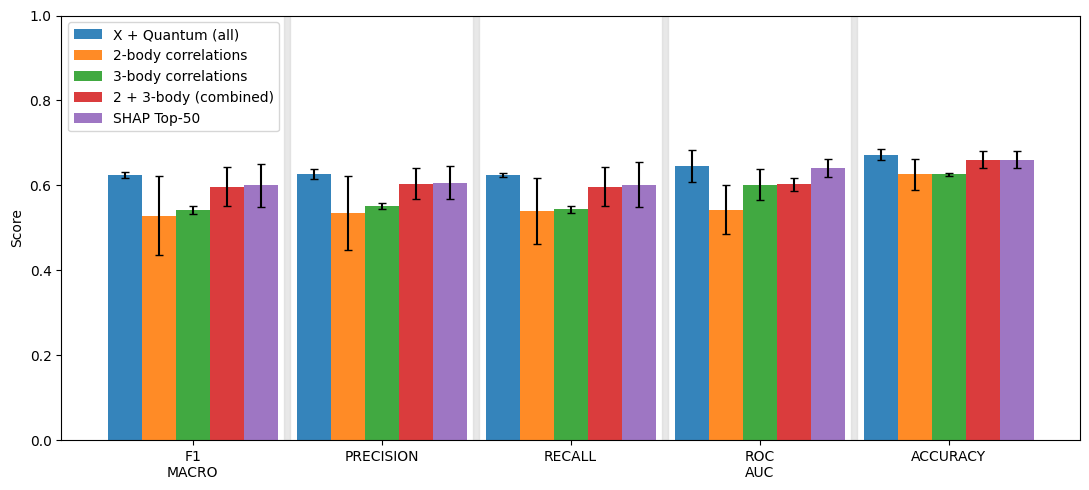

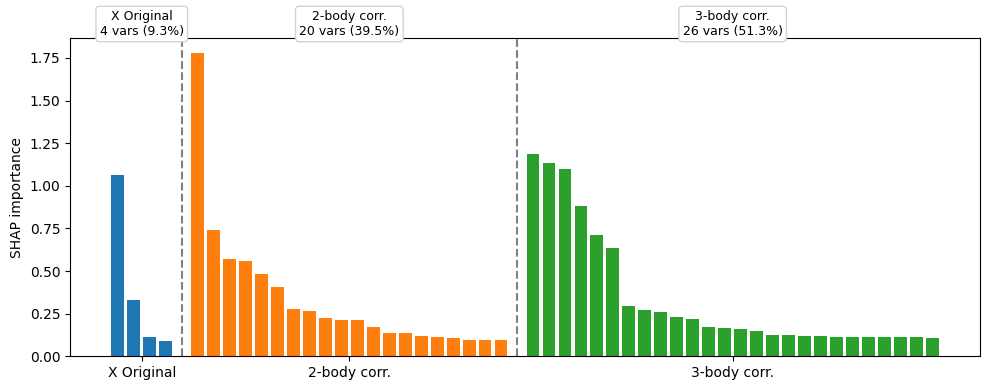

In [143]:
print_metrics_summary(results, K_MAX)

fig1, ax1 = plot_quantum_performance(results, K_MAX)
#fig1.savefig("performance_comparison.png", dpi=300)

fig2, ax2 = plot_shap_grouped_importance(results, K_MAX, top_k=NUM_FEATURES_SHAP)
#fig2.savefig("shap_grouped_importance.png", dpi=300)

In [141]:
metrics_classical = classification(X_reduced, y_raw)
print("metrics Classical:")
for metric, value in metrics_classical.items():
    print(f" {metric}: {np.round(value,3)}")

Fold number: 1
Fold number: 2
metrics Classical:
 AUC: 0.547
 F1 Macro: 0.52
 Precision Macro: 0.548
 Recall Macro: 0.526
 Accuracy: 0.614


In [ ]:
=== Classification performance (mean ± std over CV) ===

                     F1 Macro    Precision Macro  Recall Macro       AUC          Accuracy   
Model                                                                                        
Local mag.         0.508 ± 0.082   0.541 ± 0.111  0.517 ± 0.079  0.504 ± 0.064  0.614 ± 0.081
2-body corr.       0.456 ± 0.087   0.463 ± 0.123  0.484 ± 0.071  0.436 ± 0.192  0.602 ± 0.056
X + Quantum (aug)  0.447 ± 0.062   0.465 ± 0.097  0.471 ± 0.058  0.434 ± 0.179  0.584 ± 0.073
Concat SHAP50      0.494 ± 0.091   0.528 ± 0.120  0.499 ± 0.093  0.485 ± 0.159  0.590 ± 0.100